In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from datetime import datetime
from scipy.stats import skew
from sklearn.preprocessing import MinMaxScaler
from lightgbm import LGBMRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.model_selection import StratifiedKFold, train_test_split,KFold
from sklearn.metrics import roc_auc_score,average_precision_score, confusion_matrix,classification_report,precision_recall_curve,accuracy_score, recall_score, f1_score
import time
import seaborn as sns
import joblib
import shap

/Users/pg/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
train = pd.read_csv('data/lending_club_2020_train.csv')
test = pd.read_csv('data/lending_club_2020_test.csv')

/var/folders/10/60hqtvh14mx_q270xg8q82qc0000gn/T/ipykernel_9874/4166847255.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('data/lending_club_2020_train.csv')


In [4]:
df = pd.concat([train, test], axis=0).reset_index(drop=True)

In [5]:
# addr_state 유지
def drop(df):
    # 삭제할 컬럼 리스트
    drop_cols = [
        'issue_d', 'last_pymnt_d', 'term', 'risk_free',
        'installment', 'recoveries', 'total_pymnt', 
        'last_pymnt_amnt','total_rec_prncp', 'funded_amnt',
        'installment', 'int_rate', 'total_pymnt_inv', 'funded_amnt_inv',
        'grade', 'sub_grade', 'pymnt_plan', 'url', 'title', 'zip_code',
        'delinq_2yrs', 'mths_since_last_record', 'initial_list_status', 'out_prncp',
        'out_prncp_inv', 'total_pymnt', 
        'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
        'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
        'last_fico_range_high', 'last_fico_range_low', 'mths_since_last_major_derog',
        'policy_code', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
        'open_acc_6m', 'open_il_12m', 'open_il_24m', 'total_bal_il', 'open_rv_12m',
        'open_rv_24m', 'max_bal_bc', 'all_util', 'avg_cur_bal',
        'chargeoff_within_12_mths', 'delinq_amnt', 'mths_since_recent_bc_dlq',
        'mths_since_recent_revol_delinq', 'num_rev_accts', 'num_tl_120dpd_2m',
        'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',
        'sec_app_chargeoff_within_12_mths', 'hardship_flag', 'hardship_type',
        'hardship_reason', 'hardship_status', 'deferral_term', 'hardship_amount',
        'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date',
        'hardship_length', 'hardship_dpd', 'hardship_loan_status',
        'orig_projected_additional_accrued_interest',
        'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
        'debt_settlement_flag', 'emp_title', 'earliest_cr_line', 'sec_app_earliest_cr_line', 'issue_d', 'purpose',
        'sec_app_revol_util', 'sec_app_num_rev_accts',
        'sec_app_open_acc', 'il_util', 'inq_fi',
        'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_collections_12_mths_ex_med',
        'sec_app_open_act_il'
    ]
        # 결측치 행 삭제 대상 컬럼 리스트
    dropna_cols = [
        'tax_liens',
        'collections_12_mths_ex_med',
        'num_accts_ever_120_pd',
        'mo_sin_old_il_acct',
        'mo_sin_rcnt_tl',
        'mo_sin_old_rev_tl_op',
        'num_il_tl',
        'pct_tl_nvr_dlq',
        'tot_hi_cred_lim',
        'last_pymnt_d'
    ]
    # 해당 변수들 중 결측치가 있는 행 삭제
    df.dropna(subset=dropna_cols, inplace=True)

    df = df.drop(columns=drop_cols)

    return df

In [6]:
def fill_missing_values(df):
    """
    결측치 처리 전용 함수
    """
    fill_minus1_cols = [
        'sec_app_fico_range_low','sec_app_fico_range_high'
    ]

    fill_zero_cols = [
        'inq_last_12m'
    ]

    fill_999_cols = [
        'dti', 'mths_since_last_delinq', 'mths_since_rcnt_il', 'total_cu_tl',
        'open_act_il', 'mths_since_recent_inq'
    ]

    df[fill_minus1_cols] = df[fill_minus1_cols].fillna(-1)
    df[fill_zero_cols] = df[fill_zero_cols].fillna(0)
    df[fill_999_cols] = df[fill_999_cols].fillna(999)

    return df

In [7]:
def preprocess_data(df):

    """
    전처리 전체 파이프라인
    - df: 처리할 데이터프레임
    return: (전처리된 df)
    """

    # 2. 범주형 통합 및 원핫 or 순서형 인코딩

    df['application_type'] = df['application_type'].map({'Individual': 0, 'Joint App': 1})
    
    df = pd.get_dummies(df, columns=['term_norm'], prefix='term')

    # 컬럼 평균
    df["sec_app_fico_mean"] = df[["sec_app_fico_range_low", "sec_app_fico_range_high"]].mean(axis=1)
    df["total_limit_mean"] = df[["total_rev_hi_lim", "total_rev_hi_lim"]].mean(axis=1)


    # pub_rec, tax_liens: 이진 변수화
    df["pub_rec_flag"] = df["pub_rec"].apply(lambda x: 1 if x > 0 else 0)
    df["tax_liens_flag"] = df["tax_liens"].apply(lambda x: 1 if x > 0 else 0)


    # emp_length 결측치 unknown으로 바꾸고 원핫
    df['emp_length'] = df['emp_length'].fillna('Unknown')
    
    #!! addr_state 결측치 unknown으로 바꾸고 원핫
    df['addr_state'] = df['addr_state'].fillna('Unknown')


    # joint가 있으면 joint로 대체
    df['dti'] = df['dti_joint'].fillna(df['dti'])
    df['annual_inc'] = df['annual_inc_joint'].fillna(df['annual_inc'])
    df['verification_status'] = df['verification_status_joint'].fillna(df['verification_status'])
    df['revol_bal'] = df['revol_bal_joint'].fillna(df['revol_bal'])

    # 가중평균 (2:1)
    df['weighted_inq'] = (df['inq_last_6mths']*2 + df['inq_last_12m']*1) / 3



    # 원핫 인코딩 적용
    df = pd.get_dummies(df, columns=['emp_length'], prefix='emp_length')
    df = pd.get_dummies(df, columns=['home_ownership'], prefix='home')
    df = pd.get_dummies(df, columns=['verification_status'], prefix='verification_status')
    #!추가 addr_state
    df = pd.get_dummies(df, columns=['addr_state'], prefix='addr_state')


    df['revol_util'] = df['revol_util'].str.replace('%', '', regex=False).astype(float)
    # 매핑 딕셔너리 정의

    # 평균으로 대체
    df['percent_bc_gt_75'] = df['percent_bc_gt_75'].fillna(df['percent_bc_gt_75'].mean())
    df['bc_open_to_buy'] = df['bc_open_to_buy'].fillna(df['bc_open_to_buy'].mean())
    df['mths_since_recent_bc'] = df['mths_since_recent_bc'].fillna(df['mths_since_recent_bc'].mean())

    # 공동 대출 여부에 따라 결측치를 해당 그룹의 중앙값으로 대체
    cols_to_impute = ['revol_util', 'bc_util']

    for col in cols_to_impute:
        imputed_values = df.groupby('application_type')[col].transform('median')
        df[col] = df[col].fillna(imputed_values)


    # 원래 열 제거
    df.drop(columns=['dti_joint'], inplace=True)
    df.drop(columns=['annual_inc_joint'], inplace=True)
    df.drop(columns=['verification_status_joint'], inplace=True)
    df.drop(columns=['revol_bal_joint'], inplace=True)

    return df

In [8]:
def log_transform(df):
    # 숫자형 컬럼 추출
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

    # 로그 변환 제외 컬럼 (id, target, 주소 등)
    exclude_cols = ['id']
    numeric_cols = [col for col in numeric_cols if col not in exclude_cols]

    # 2개 이하 unique 값 제외
    sequence_cols = [n for n in numeric_cols if df[n].nunique() > 2]

    # 각 컬럼의 왜도 계산
    skewness = df[sequence_cols].apply(lambda x: skew(x.dropna()))
    high_skew_cols = skewness[skewness.abs() > 1].index.tolist()

    # 로그 변환
    for col in high_skew_cols:
        df[col] = np.log1p(df[col].clip(lower=1e-6))

    return df

In [9]:
def split_data(df, target_col='excess_return'):
    """
    ✅ 회귀 모델 학습용 데이터 분리 함수
    - target: excess_return (또는 irr)
    - NaN 제거
    - 불필요한 컬럼 드롭
    """
    # 1️⃣ 타깃 결측 제거
    df = df[df[target_col].notna()].copy()

    # 2️⃣ X / y 분리
    y = df[target_col]
    drop_cols = [target_col]


    X = df.drop(columns=drop_cols)

    return X, y

In [10]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import numpy_financial as npf
from datetime import datetime
from dateutil.relativedelta import relativedelta

def normalize_term(x):
    s = str(x)
    if "36" in s: return 36
    if "60" in s: return 60
    return pd.NA

def get_excess_return(df):
    
    df["issue_d"] = pd.to_datetime(df["issue_d"], errors="coerce")
    df["term_norm"] = df["term"].apply(normalize_term)
    
    # 1) FRED 금리 (3Y/5Y) 내려받기
    start = df["issue_d"].min() - pd.Timedelta(days=7)
    end   = df["issue_d"].max() + pd.Timedelta(days=7)
    
    rf = web.DataReader(["DGS3", "DGS5"], "fred", start, end)  # index=DATE
    rf = rf.rename(columns={"DGS3": "rf_3y", "DGS5": "rf_5y"})
    
    # 2) df 날짜 기준으로 reindex, 휴일은 직전 영업일 값으로
    rf_matched = rf.reindex(df["issue_d"], method="ffill")
    
    # 3) FRED 원천에 NaN이 있으면 최근 영업일 값으로 다시 ffill/bfill
    rf_matched = rf_matched.ffill().bfill()
    
    # 4) 행별 만기에 맞춰 risk_free 선택 후 소수 변환
    df["risk_free"] = np.where(
        df["term_norm"].eq(36), rf_matched["rf_3y"] / 100.0,
        np.where(df["term_norm"].eq(60), rf_matched["rf_5y"] / 100.0, np.nan)
    )
    
    # (선택) 간단 점검
    # 유효 만기 행에서 누락 몇 개?
    mask = df["issue_d"].notna() & df["term_norm"].isin([36,60])
    print("결측 개수:", df.loc[mask, "risk_free"].isna().sum())
    df['risk_free'].dropna(inplace=True)
    df['risk_free'] = df['risk_free']*(1/12)
    print(df[["issue_d","term_norm","risk_free"]].head())

    # 부도 여부: Fully Paid → 0, Charged Off,Default → 1
    status_map = {
        'Fully Paid': 0,
        'Charged Off': 1,
        'Default' : 1
    }
    df['loan_status'] = df['loan_status'].map(status_map)
    
    # 6.타깃값 0/1만 남기기
    df = df[df['loan_status'].isin([0, 1])].copy()

    

    # 날짜 형식 변환
    df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y')  # 예: Jan-2020
    df['last_pymnt_d'] = pd.to_datetime(df['last_pymnt_d'], format='%b-%Y')
    
    # 개월 수 계산
    df['n_months'] = df.apply(lambda row: max(1, (row['last_pymnt_d'].year - row['issue_d'].year) * 12 +
                                               (row['last_pymnt_d'].month - row['issue_d'].month)), axis=1)

    
        
    df['irr'] = df.apply(calc_irr_by_threshold, axis=1)  # y로 사용
    # -----------------------------
    # 3) Risk-free 비교 및 파생
    # -----------------------------
    # risk_free는 이미 존재한다고 했으므로 그대로 사용하되, 단위 보정만
    
    df['excess_return'] = df['irr'] - df['risk_free']
    
    # -----------------------------
    # 4) 점검
    # -----------------------------
    print("IRR(연환산) 평균:", df['irr'].mean())
    print("IRR(연환산) 중앙값:", df['irr'].median())
    print("IRR < 0 비율:", (df['irr'] < 0).mean())
    print("IRR > risk_free 비율:", len(df[df['excess_return']>0]) / len(df))
    
    cols_show = ['id', 'loan_amnt', 'installment',
                 'loan_status',
                 'n_months', 'irr', 'excess_return']
    
    
    print(df[cols_show].head(10))
    return df.drop(columns=['irr', 'n_months'])

# 4. IRR 계산 함수 정의
def calc_irr_by_threshold(row):
    try:
        loan_amnt = row['loan_amnt']
        term = int(row['term_norm'])
        installment = row['installment']
        recoveries = row['recoveries']
        elapsed = row['n_months']
        total_pymnt = row['total_pymnt'] # 회계 기준일에 처리된 총액
        loan_status = row['loan_status']
        last_pymnt = row['last_pymnt_amnt'] # 납부된 당일 금액
        cashflow = []
        if loan_status==0: # 부도 안냄
            if elapsed < term: # 조기상환
                if elapsed <= 1: # 1달만에 갚으면 분모가 0이 되버림 (밑에 /(elapsed-1) 때문에)
                    cashflow = [-loan_amnt] + [total_pymnt]
                else:
                    actual_monthly_payment = (total_pymnt-last_pymnt) / (elapsed-1)
                    cashflow = [-loan_amnt] + [actual_monthly_payment] * (elapsed-1) + [last_pymnt]
            else: # 정상 상환
                cashflow = [-loan_amnt] + [installment] * term
        else: # 투자했는데 부도냄
            cashflow = [-loan_amnt] + [installment] * (elapsed-1) + [last_pymnt, recoveries]
        irr_value = npf.irr(cashflow)
        return float(irr_value) if np.isfinite(irr_value) else np.nan

    except Exception as e:
        print(f"Error at row {row.name}: {e}")
        return np.nan


In [11]:
best_model = joblib.load('best_model_IRR_ty.pkl')

In [12]:
test = get_excess_return(test)


결측 개수: 0
     issue_d  term_norm  risk_free
0 2013-03-01         36   0.000292
1 2019-07-01         60   0.001492
2 2019-12-01         36   0.001342
3 2014-03-01         60   0.001258
4 2015-11-01         60   0.001267
IRR(연환산) 평균: -0.014292308918358195
IRR(연환산) 중앙값: 0.009159275356366514
IRR < 0 비율: 0.17430245175985215
IRR > risk_free 비율: 0.8173602754738063
          id  loan_amnt  installment  loan_status  n_months       irr  \
0    3697367    20000.0       608.72          0.0        36  0.005026   
3   13046178    12000.0       283.22          1.0        15 -0.060394   
6   69533136    15000.0       451.73          0.0        25  0.004466   
7    6134635    20000.0       674.37          0.0        10  0.010875   
10  46705240    11150.0       381.03          0.0        25  0.011417   
11  65483078    14000.0       451.68          0.0        29  0.008212   
12  23924970    16000.0       546.69          0.0        36  0.011650   
14  24006145    25000.0       906.83          1.0       

In [13]:
test['credit_utilization_ratio'] = test['total_bal_ex_mort'] / (test['total_bc_limit'] + 1) #신용카드 한도 대비 실제 부채 사용률
test['loan_per_month'] = test['loan_amnt'] / (test['term_norm'] + 1)
test['loan_income_ratio'] = test['loan_amnt'] / (test['annual_inc'] + 1)
test['fico_mean'] = (test['fico_range_low'] + test['fico_range_high']) / 2
test['loan_to_credit_limit'] = test['loan_amnt'] / (test['tot_hi_cred_lim'] + 1)
test['mortgage_ratio'] = test['mort_acc'] / (test['total_acc'] + 1)
test['high_utilization_score'] = (test['percent_bc_gt_75'] * test['bc_util']) / 100

test['addr_state_IA'] =0
test['loan_per_month'] = pd.to_numeric(test['loan_per_month'], errors='coerce')

In [14]:
# 1️⃣ Drop
test = drop(test)

# 2️⃣ 결측치 처리
test = fill_missing_values(test)

# 3️⃣ 데이터 전처리 (스케일링, 원핫인코딩 등)
test = preprocess_data(test)

In [15]:
#도움안되는 녀석들 삭제
drop_columns = [
    'addr_state_ID', 'addr_state_KY', 'addr_state_ND', 'addr_state_TN', 'addr_state_NE',
    'addr_state_NH', 'addr_state_DE', 'addr_state_NV',
    'emp_length_1 year', 'emp_length_4 years', 'emp_length_6 years', 'emp_length_8 years',
    #'home_ANY', 'home_OTHER', 'home_NONE',
    'addr_state_KS', 'addr_state_AK', 'addr_state_HI'
]
test.drop(columns=drop_columns, inplace=True)

In [16]:
test_X, test_y= split_data(test)
test_X = log_transform(test_X)

In [17]:
test_X = test_X.drop(columns=['id'], errors='ignore')  

In [18]:
best_model = joblib.load('best_model_IRR_ty.pkl')

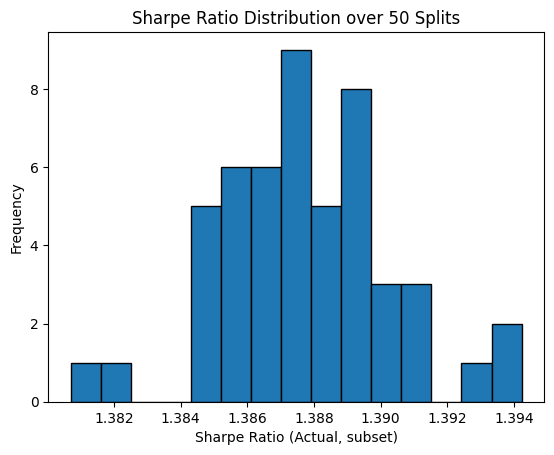

📌 평균 Sharpe Ratio: 1.3878
📌 표준편차: 0.0026
📌 최소값: 1.3807 | 최대값: 1.3942


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

N = 50  # 반복 횟수
sharpe_scores = []

def _sharpe(arr):
    arr = np.asarray(arr, dtype=float)
    mu, sd = np.nanmean(arr), np.nanstd(arr)
    return np.nan if sd == 0 or np.isnan(sd) else mu / (sd + 1e-9)

for i in range(N):
    # split
    X_train, X_valid, y_train, y_valid = train_test_split(
        test_X, test_y, test_size=0.3, random_state=i
    )
    
    # 예측
    y_pred = best_model.predict(X_valid)

    # ---- 네 Sharpe 로직 ----
    sel_pred = pd.Series(np.where(y_pred < 0, 0, y_pred)).astype(float)
    sel_true = pd.Series(np.where(y_pred < 0, 0, y_valid)).astype(float)

    # NA 제거
    sel_pred = sel_pred.dropna()
    sel_true = sel_true.dropna()

    # 실제 Sharpe Ratio
    sharpe_true = _sharpe(sel_true)

    # 모으기
    sharpe_scores.append(sharpe_true)

# -----------------------------
# 결과 분포 시각화
# -----------------------------
plt.hist(sharpe_scores, bins=15, edgecolor="black")
plt.title(f"Sharpe Ratio Distribution over {N} Splits")
plt.xlabel("Sharpe Ratio (Actual, subset)")
plt.ylabel("Frequency")
plt.show()

print(f"📌 평균 Sharpe Ratio: {np.nanmean(sharpe_scores):.4f}")
print(f"📌 표준편차: {np.nanstd(sharpe_scores):.4f}")
print(f"📌 최소값: {np.nanmin(sharpe_scores):.4f} | 최대값: {np.nanmax(sharpe_scores):.4f}")

In [20]:
sharpe_scores

[1.389391968508615,
 1.3868801116238367,
 1.3908423828771763,
 1.385475251068888,
 1.3907944235597576,
 1.3858681208296073,
 1.3883931482881313,
 1.3851878729894262,
 1.3873960815481043,
 1.388814470990112,
 1.3940256847407717,
 1.388439645669099,
 1.3887446411265072,
 1.3912084646909897,
 1.3872065655261283,
 1.3889187263236966,
 1.3848020796421385,
 1.3850750641180078,
 1.386418884193907,
 1.3845417303492056,
 1.3858116313597761,
 1.3852673775689506,
 1.3889182449676216,
 1.386547524457179,
 1.388944543460935,
 1.3875568019363997,
 1.3867056860568596,
 1.3872235599400498,
 1.3904131833257591,
 1.3854148860600528,
 1.3875431626575216,
 1.3932932979367973,
 1.38789282684528,
 1.387292217183881,
 1.3822909764906837,
 1.3890494301392482,
 1.3902422085137358,
 1.3890495374343672,
 1.3942264753539986,
 1.386207312675082,
 1.3859784153408286,
 1.3888517934130333,
 1.3807003691495863,
 1.388813250894808,
 1.3850003293944404,
 1.3900239386939572,
 1.3893607615623513,
 1.387770673524838,
 1.38

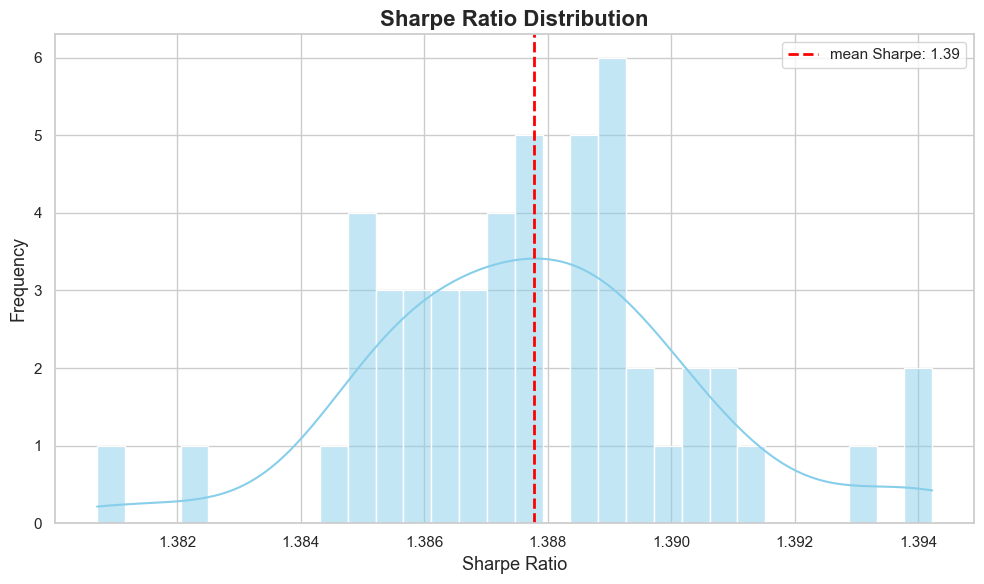

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화 스타일 설정
sns.set(style="whitegrid", palette="pastel")

plt.figure(figsize=(10, 6))
sns.histplot(sharpe_scores, bins=30, kde=True, color="skyblue", edgecolor="white")

# 평균선 표시
mean_val = sum(sharpe_scores) / len(sharpe_scores)
plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'mean Sharpe: {mean_val:.2f}')

# 제목과 라벨 설정
plt.title("Sharpe Ratio Distribution", fontsize=16, fontweight='bold')
plt.xlabel("Sharpe Ratio", fontsize=13)
plt.ylabel("Frequency", fontsize=13)

# 범례와 스타일
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()



----